## Novel Molecule Generation using Bidirectional-Recurrent Neural Networks with Attention Applied to Simplified Molecular Input Line Entry Sysem (SMILES)

author: anthony j. vasquez
email: vanthony715@gmail.com / avasque1@jh.edu

In [1]:
import time
from datetime import datetime
t0 = time.time()

import sys
sys.path.append('./data/')

import gc
gc.collect()

import os
##had a hard time with this setting on windows os using spyder and jypyter
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import warnings
warnings.filterwarnings("ignore")

import platform
print("Operating System: ", platform.system())
print("Machine Type:: ", platform.machine())

import multiprocessing as mp
max_processors = mp.cpu_count()
print('Processor Count: ', max_processors, '\n')

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import train_test_split

from rdkit import Chem
from rdkit.Chem import BRICS
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem.Descriptors import CalcMolDescriptors
from rdkit.Chem.rdMolDescriptors import GetHashedMorganFingerprint

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset

if torch.cuda.is_available():
    torch.cuda.empty_cache() #empty cache
    print('CUDA Version')
    print(f'CUDNN Version: {torch.backends.cudnn.version()}')
    print(f'Number of CUDA Devices: {torch.cuda.device_count()}')
    print(f'Active CUDA Device: {torch.cuda.current_device()}')
    print(f'Available devices: {torch.cuda.device_count()}, Name: {torch.cuda.get_device_name(0)}')
    print(f'Current CUDA device: {torch.cuda.current_device()}')
    print('\n')

##hardware params
# DEVICE = torch.device('cpu') #DEBUG
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using Device: \n', DEVICE)

Operating System:  Linux
Machine Type::  x86_64
Processor Count:  24 

CUDA Version
CUDNN Version: 90100
Number of CUDA Devices: 2
Active CUDA Device: 0
Available devices: 2, Name: NVIDIA RTX A4000
Current CUDA device: 0


Using Device: 
 cuda


#### Hyperparameters

In [2]:
##OS
LINUX = True
MULTI_GPU = True #trains using multiple gpus
N_PROCESSORS = max_processors - 2

##data
HOLDOUT_PERC = 0.85
TRAIN_BS = 576 #train batch size
PREFETCH_FACTOR = 4 #effectively reduces gpu load time 
NUM_WORKERS = 8

##training
N_EPOCHS = 50 #num of training epochs
LRG = 0.000025 #learning rate generator
LRD = 0.0000025 #learning rate discriminator
LRS_SZ = 5 #learning rate scheduler step size
LRS_GAMMA = 0.1 #learning rate scheduler gamma
BETAS = (0.5, 0.999) #momentum moving average
DROPOUT_PROB = 0.25 #dropout
WEIGHT_DECAY = 1e-5 #L2 Regularization
RUN_EXTRA_TIMES = 3 #iterate over validator extra times for every one time that the generator ates
EMBEDDING_DIM = 32 #how large of a vector to represent input data
HIDDEN_DIM = 64 #learned embeddings
BIDIRECTIONAL = True #makes gru layer bidirectional
N_HEADS = 4 #number of heads for attention, scaled dot-product for head's respective section of sequence
CLIP_VALUE = 0.01 ##WGAN discriminator clip value for training stabalization

##inference
N_SAMPLES = 1000
MAX_LENGTH = 10

##visualization params
SIGMA = 2 #loss smoothing for lineplot
PRINT_LOSS_EVERY = 2 #how many epochs to output loss

##logging
RESULTS_PATH = './results/'

In [3]:
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")

def make_dir(path: str) -> None:
    '''
    Create results directory
    '''
    import shutil
    if os.path.isdir(path):
        shutil.rmtree(path)
    os.makedirs(path)
    print('Created Folder at: ', path)

WRITEPATH = RESULTS_PATH + 'epoch_'+ str(N_EPOCHS) + '_exper_at_datetime_' + dt_string
make_dir(WRITEPATH)

Created Folder at:  ./results/epoch_50_exper_at_datetime_19-08-2024_16-40-19


#### Download Utils

In [4]:
def get_mol(smiles):
    '''
    Converts SMILES string to a RDKit MOL object
    '''
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return mol

def getMolecularDescriptors(smiles):

    '''
    Extract RDKit molecular descriptors
    '''
    features = CalcMolDescriptors(get_mol(smiles))
    return np.array(list(features.values()))

#### Open SMILES Data

In [5]:
%%time

### Import the data
data_file = pd.read_csv('./data/Zinc_all_smiles_data.txt', header = None)
data_file.columns = ['smiles']
smilesList = data_file['smiles'].tolist()

##split dset
train_smiles, holdout_smiles, _, _ = train_test_split(smilesList, smilesList, test_size=HOLDOUT_PERC, random_state=42)
print('Len all smiles: ', len(smilesList))
print('Len train smiles: ', len(train_smiles))
print('Len holdout smiles: ', len(holdout_smiles))

Len all smiles:  249456
Len train smiles:  37418
Len holdout smiles:  212038
CPU times: user 234 ms, sys: 10.1 ms, total: 244 ms
Wall time: 257 ms


In [6]:
import re
from collections import defaultdict

def tokenize_smiles(smiles: str) -> list:
    '''
    Generate tokens
    '''
    pattern = r"(\[[^\[\]]*\])"
    tokens = re.split(pattern, smiles)
    return [token for token in tokens if token]

def build_vocabulary(smiles_list: list) -> dict:
    '''
    Build reference vocab
    '''
    vocab = defaultdict(int)
    for smiles in smiles_list:
        tokens = tokenize_smiles(smiles)
        for token in tokens:
            if token not in vocab:
                vocab[token] = len(vocab) + 1
    return vocab

def encode_smiles(smiles: str, vocab: dict) -> list:
    '''
    Encodes (tokenizes) smiles 
    '''
    tokens = tokenize_smiles(smiles)
    return [vocab[token] for token in tokens]

def decode_smiles(encoded_smiles: list, vocab: dict) -> str:
    '''
    Decodes (de-tokenizes) smiles
    '''
    inv_vocab = {v: k for k, v in vocab.items()}
    return ''.join([inv_vocab[token] for token in encoded_smiles])

In [7]:
%%time

# Example usage:
vocab = build_vocabulary(smilesList)
max_length = max(len(tokenize_smiles(smiles)) for smiles in smilesList)

print('\n')



CPU times: user 625 ms, sys: 19.2 ms, total: 644 ms
Wall time: 643 ms


In [8]:
class SMILESDataset(Dataset):
    def __init__(self, smiles_list: list, vocab: dict, max_length: int) -> None:
        '''
        Custom smiles dataset
        '''
        self.smiles_list = smiles_list
        self.vocab = vocab
        self.max_length = max_length

    def __len__(self):
        '''
        Required
        '''
        return len(self.smiles_list)

    def __getitem__(self, idx: int) -> torch.tensor:
        '''
        Required
        '''
        smiles = self.smiles_list[idx]
        encoded = encode_smiles(smiles, self.vocab)
        padded = encoded + [0] * (self.max_length - len(encoded))
        return torch.tensor(padded, dtype=torch.long)

In [9]:
%%time

##define dataset
dataset = SMILESDataset(train_smiles, vocab, max_length)

##runs slightly faster using linux, because able to use num_workers > 0
if LINUX:
    dataloader = DataLoader(dataset, batch_size=TRAIN_BS, shuffle=True, pin_memory=True, prefetch_factor=PREFETCH_FACTOR, num_workers=NUM_WORKERS)
else:
    ##windows
    dataloader = DataLoader(dataset, batch_size=TRAIN_BS, shuffle=True, pin_memory=True)

print('Data Summary: ')
print('smilesList Len: ', len(smilesList))
print('vocab len: ', len(vocab))
print('max_length: ', max_length)
print('\n')

Data Summary: 
smilesList Len:  249456
vocab len:  254593
max_length:  27


CPU times: user 216 µs, sys: 29 µs, total: 245 µs
Wall time: 241 µs


In [10]:
class Generator(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_dim: int, max_length: int, num_heads: int):
        '''
        Bidirectional Recurrent Generator with Attention Layer
        '''
        super(Generator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  #generate embeddings
        self.gru = nn.GRU(embedding_dim, hidden_dim, dropout=DROPOUT_PROB, batch_first=True, bidirectional=BIDIRECTIONAL) #gru instead of lstm
        if BIDIRECTIONAL: #if bidirectional, multiply by 2
            self.attention = nn.MultiheadAttention(hidden_dim*2, num_heads, dropout=DROPOUT_PROB)
            self.fc = nn.Linear(hidden_dim * 2, vocab_size)
        else:
            self.attention = nn.MultiheadAttention(hidden_dim, num_heads, dropout=DROPOUT_PROB)
            self.fc = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(DROPOUT_PROB) #very prone to overfitting, so dropout or some type of regularization is needed
        self.max_length = max_length

    def forward(self, z: torch.tensor) -> torch.tensor:
        '''
        Builds graph and forwards
        '''
        embedded = self.embedding(z)  # Shape: (batch_size, max_length, embedding_dim)
        gru_out, _ = self.gru(embedded)  # Shape: (batch_size, max_length, hidden_dim)
        gru_out = self.dropout(gru_out)
        
        #multi-head attention (MultiheadAttention expects (seq_len, batch_size, hidden_dim))
        attn_input = gru_out.transpose(0, 1)  #Transpose -> (max_length, batch_size, hidden_dim)
        attn_out, _ = self.attention(attn_input, attn_input, attn_input)  # Self-attention
        attn_out = attn_out.transpose(0, 1)  # Transpose back -> (batch_size, max_length, hidden_dim)

        output = self.fc(attn_out)  #output layer
        output_indices = torch.argmax(output, dim=-1)  #Convert from continous to discrete indices for Discriminator emvedding layer
        return output_indices 

class Discriminator(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_dim: int, max_length: int, num_heads: int) -> None:
        '''
        Bidirectional Recurrent Discriminator with Attention Layer
        '''
        super(Discriminator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, dropout=DROPOUT_PROB, batch_first=True, bidirectional=BIDIRECTIONAL)

        ##if bidirectional, then reduce the hidden dimensionality using fully connected of hid_size/2
        if BIDIRECTIONAL:
            self.fc_reduce = nn.Linear(hidden_dim * 2, hidden_dim)  #reduce dim

        ##attend
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads, dropout=DROPOUT_PROB)
        self.fc = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(DROPOUT_PROB)
        self.max_length = max_length

    def forward(self, x: torch.tensor) -> torch.tensor:
        '''
        Builds graph and forwards
        '''
        embedded = self.embedding(x)  #shape: (batch_size, max_length, embedding_dim)
        gru_out, _ = self.gru(embedded)  #shape: (batch_size, max_length, hidden_dim)
        gru_out = self.fc_reduce(gru_out)  #reduce dimension -> hidden_dim
        gru_out = self.dropout(gru_out)

        ##ulti-head attention
        attn_input = gru_out.transpose(0, 1)  #transpose -> (max_length, batch_size, hidden_dim)
        attn_out, _ = self.attention(attn_input, attn_input, attn_input)  #self-attention
        attn_out = attn_out.transpose(0, 1)  #transpose -> (batch_size, max_length, hidden_dim)

        ##take the last output from the sequence (many-to-one)
        output = self.fc(attn_out[:, -1, :])  ##hape: (batch_size, 1)
        return torch.sigmoid(output)  ##igmoid for binary classification

### Instantiate GAN and Discriminator Networks

In [11]:
%%time

def count_parameters(model: object) -> int:
    '''
    Counts total network parameters
    '''
    return sum(p.numel() for p in model.parameters())

def count_trainable_parameters(model):
    '''
    Only counts trainable parameters
    '''
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

##init networks
n_gen = Generator(vocab_size=len(vocab) + 1, embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, max_length=max_length, num_heads=N_HEADS).to(DEVICE)
n_disc = Discriminator(vocab_size=len(vocab) + 1, embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, max_length=max_length, num_heads=N_HEADS).to(DEVICE)

if MULTI_GPU:
    ##for multi-gpu
    n_gen = nn.DataParallel(n_gen)
    n_disc = nn.DataParallel(n_disc)

##set optimization
g_opt = optim.Adam(n_gen.parameters(), lr=LRG, betas=BETAS, weight_decay=WEIGHT_DECAY)
d_opt = optim.Adam(n_disc.parameters(), lr=LRD, betas=BETAS, weight_decay=WEIGHT_DECAY)

##set schedulers
schedule_g = StepLR(g_opt, step_size=LRS_SZ, gamma=LRS_GAMMA)
schedule_d = StepLR(d_opt, step_size=LRS_SZ, gamma=LRS_GAMMA)

##init criterion
crit = nn.BCELoss()

print('\n')



CPU times: user 1.48 s, sys: 411 ms, total: 1.89 s
Wall time: 2.59 s


### Generator Network

In [12]:
print('\nTotal generator param cnt: ', count_parameters(n_gen))
print('Trainable generator param cnt: ', count_trainable_parameters(n_gen))


Total generator param cnt:  41093314
Trainable generator param cnt:  41093314


In [13]:
n_gen

DataParallel(
  (module): Generator(
    (embedding): Embedding(254594, 32)
    (gru): GRU(32, 64, batch_first=True, dropout=0.25, bidirectional=True)
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (fc): Linear(in_features=128, out_features=254594, bias=True)
    (dropout): Dropout(p=0.25, inplace=False)
  )
)

### Descriminator Network

In [14]:
print('\nTotal discriminator param cnt: ', count_parameters(n_disc))
print('Trainable discriminator param cnt: ', count_trainable_parameters(n_disc))


Total discriminator param cnt:  8209601
Trainable discriminator param cnt:  8209601


In [15]:
n_disc

DataParallel(
  (module): Discriminator(
    (embedding): Embedding(254594, 32)
    (gru): GRU(32, 64, batch_first=True, dropout=0.25, bidirectional=True)
    (fc_reduce): Linear(in_features=128, out_features=64, bias=True)
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
    )
    (fc): Linear(in_features=64, out_features=1, bias=True)
    (dropout): Dropout(p=0.25, inplace=False)
  )
)

### Train GAN

In [16]:
import torch.optim as optim

def train_gan(generator: object, discriminator: object, g_optimizer: object, d_optimizer: object, criterion: object, g_schedule: object, d_schedule: object, data_loader: object, 
              n_epochs: int, device: object) -> tuple:
    '''
    Simple GAN Trainer
    '''
    history = {'epoch': [] ,'g_loss': [], 'd_loss': []}
    for epoch in range(n_epochs):
        t1 = time.time()
        for real_smiles in tqdm(data_loader):
            batch_size = real_smiles.size(0)

            ##according to WGAN, this should help to stabalize training, original number was 5 -times disc updates to every 1 gen updates
            if RUN_EXTRA_TIMES:
                for i in range(RUN_EXTRA_TIMES):
                    ##-----train discriminator-----
                    d_optimizer.zero_grad()
        
                    ##generate real and fake labels (real are ones and fake are zeros)
                    real_labels = torch.ones(batch_size, 1).to(device)
                    fake_labels = torch.zeros(batch_size, 1).to(device)
        
                    ##gen real smiles and forward pass discriminator
                    real_smiles = real_smiles.to(device)
                    real_outputs = discriminator(real_smiles)
        
                    ##calc binary loss
                    d_loss_real = criterion(real_outputs, real_labels)
        
                    ##if multi-gpu, then need to use network module, otherwise use network directrly
                    if MULTI_GPU:
                        noise = torch.randint(1, generator.module.max_length, (batch_size, generator.module.max_length)).to(DEVICE)
                    else:
                        noise = torch.randint(1, generator.max_length, (batch_size, generator.max_length)).to(device)
        
                    ##get fake smiles by forward passing generator
                    fake_smiles = generator(noise)
                    fake_smiles = fake_smiles.long()
        
                    ##show fake smiles to discriminator then calculate loss based on what the discriminator thinks is fake
                    fake_outputs = discriminator(fake_smiles)
                    d_loss_fake = criterion(fake_outputs, fake_labels)
                    
                    ##TODO: Add gradient clipping by following WGAN-GC
                    ##TODO: Maybe wights clipping according to WGAN
                    
                    ##sum loss, backprop, and update weights
                    d_loss = d_loss_real + d_loss_fake
                    d_loss.backward()
                    d_optimizer.step()

                    ##Apply weight clipping to discriminator
                    for p in discriminator.parameters():
                        p.data.clamp_(-CLIP_VALUE, CLIP_VALUE)

            ##-----Train Generator-----
            g_optimizer.zero_grad()

            ##reused noise vector
            fake_smiles = generator(noise)
            fake_smiles = fake_smiles.long()

            ###show fake smiles 
            fake_outputs = discriminator(fake_smiles)

            ##calculate the generated loss by comparing fake_outputs to real_labels
            ##want these two to have very low loss
            ##back prop and update weights
            g_loss = criterion(fake_outputs, real_labels)
            g_loss.backward()
            g_optimizer.step()

        ##Logging and Displaying Losses
        if (epoch) % PRINT_LOSS_EVERY == 0:
            t2 = time.time() - t1
            print(f'Epoch [{epoch}/{n_epochs}], D Loss: {d_loss.item():.5f}, G Loss: {g_loss.item():.5f}, Runtime/Epoch: {t2:.5f}')

        ##Step Schedulers
        g_schedule.step()
        d_schedule.step()
        
        ##record Losses
        history['epoch'].append(epoch)
        history['g_loss'].append(g_loss.item())
        history['d_loss'].append(d_loss.item())
        
    return history, generator, discriminator

In [17]:
%%time

hist, gnet, dnet =  train_gan(generator=n_gen, discriminator=n_disc, g_optimizer=g_opt, d_optimizer=d_opt, criterion=crit, 
                              g_schedule=schedule_g, d_schedule=schedule_d, data_loader=dataloader, n_epochs=N_EPOCHS, device=DEVICE)

##save both networks
torch.save({'model_state_dict': gnet.state_dict(), 'epoch': N_EPOCHS}, WRITEPATH + '/gnet.pt')
torch.save({'model_state_dict': dnet.state_dict(), 'epoch': N_EPOCHS}, WRITEPATH + '/dnet.pt')

print('\n')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:50<00:00,  1.29it/s]


Epoch [0/50], D Loss: 1.38632, G Loss: 0.68838, Runtime/Epoch: 50.29149


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:46<00:00,  1.38it/s]


Epoch [2/50], D Loss: 1.38631, G Loss: 0.68895, Runtime/Epoch: 47.00167


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:48<00:00,  1.35it/s]


Epoch [4/50], D Loss: 1.38631, G Loss: 0.68953, Runtime/Epoch: 48.08108


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:48<00:00,  1.34it/s]


Epoch [6/50], D Loss: 1.38631, G Loss: 0.68959, Runtime/Epoch: 48.65028


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:48<00:00,  1.34it/s]


Epoch [8/50], D Loss: 1.38631, G Loss: 0.68965, Runtime/Epoch: 48.53869


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:48<00:00,  1.34it/s]


Epoch [10/50], D Loss: 1.38631, G Loss: 0.68969, Runtime/Epoch: 48.44126


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:48<00:00,  1.34it/s]


Epoch [12/50], D Loss: 1.38631, G Loss: 0.68970, Runtime/Epoch: 48.42031


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:48<00:00,  1.35it/s]


Epoch [14/50], D Loss: 1.38631, G Loss: 0.68970, Runtime/Epoch: 48.22098


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:48<00:00,  1.34it/s]


Epoch [16/50], D Loss: 1.38631, G Loss: 0.68970, Runtime/Epoch: 48.45207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:48<00:00,  1.35it/s]


Epoch [18/50], D Loss: 1.38631, G Loss: 0.68970, Runtime/Epoch: 48.27743


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:48<00:00,  1.34it/s]


Epoch [20/50], D Loss: 1.38631, G Loss: 0.68970, Runtime/Epoch: 48.47817


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:48<00:00,  1.35it/s]


Epoch [22/50], D Loss: 1.38631, G Loss: 0.68970, Runtime/Epoch: 48.20695


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:48<00:00,  1.35it/s]


Epoch [24/50], D Loss: 1.38631, G Loss: 0.68970, Runtime/Epoch: 48.21482


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:48<00:00,  1.35it/s]


Epoch [26/50], D Loss: 1.38631, G Loss: 0.68970, Runtime/Epoch: 48.14324


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:48<00:00,  1.35it/s]


Epoch [28/50], D Loss: 1.38631, G Loss: 0.68970, Runtime/Epoch: 48.28822


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:48<00:00,  1.34it/s]


Epoch [30/50], D Loss: 1.38631, G Loss: 0.68970, Runtime/Epoch: 48.35550


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:48<00:00,  1.35it/s]


Epoch [32/50], D Loss: 1.38631, G Loss: 0.68970, Runtime/Epoch: 48.13831


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:48<00:00,  1.34it/s]


Epoch [34/50], D Loss: 1.38631, G Loss: 0.68970, Runtime/Epoch: 48.51935


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:48<00:00,  1.34it/s]


Epoch [36/50], D Loss: 1.38631, G Loss: 0.68970, Runtime/Epoch: 48.51615


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:48<00:00,  1.35it/s]


Epoch [38/50], D Loss: 1.38631, G Loss: 0.68970, Runtime/Epoch: 48.31971


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:48<00:00,  1.34it/s]


Epoch [40/50], D Loss: 1.38631, G Loss: 0.68970, Runtime/Epoch: 48.36183


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:48<00:00,  1.35it/s]


Epoch [42/50], D Loss: 1.38631, G Loss: 0.68970, Runtime/Epoch: 48.25672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:48<00:00,  1.35it/s]


Epoch [44/50], D Loss: 1.38631, G Loss: 0.68970, Runtime/Epoch: 48.11401


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:48<00:00,  1.34it/s]


Epoch [46/50], D Loss: 1.38631, G Loss: 0.68970, Runtime/Epoch: 48.44502


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:48<00:00,  1.35it/s]


Epoch [48/50], D Loss: 1.38631, G Loss: 0.68970, Runtime/Epoch: 48.22846


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:48<00:00,  1.34it/s]




CPU times: user 1h 2min 6s, sys: 15min 47s, total: 1h 17min 53s
Wall time: 40min 29s


In [18]:
def plot_losses(history: dict, sigma: int, save: bool) -> None:
    '''
    Plots discriminator and generator losses on same axis 
    '''
    fig, axes = plt.subplots(2, 1, sharex=True)

    ##populate upper plot
    axes[0].plot(history['epoch'], gaussian_filter1d(history['g_loss'], sigma=sigma), label='g_loss')
    axes[0].set_ylabel('Generator Loss')

    ##populate lower plot
    axes[1].plot(history['epoch'], gaussian_filter1d(history['d_loss'], sigma=sigma), c='orange', label='d_loss')
    axes[1].set_ylabel('Discriminator Loss')

    ##configure plots
    axes[0].grid()
    axes[1].grid()
    axes[0].legend(loc='best')
    axes[1].legend(loc='best')
    axes[1].set_xlabel('Epochs')
    fig.suptitle('Generator and Discriminator Losses')
    
    if save:
        plt.savefig(WRITEPATH + '/train_losses.png')

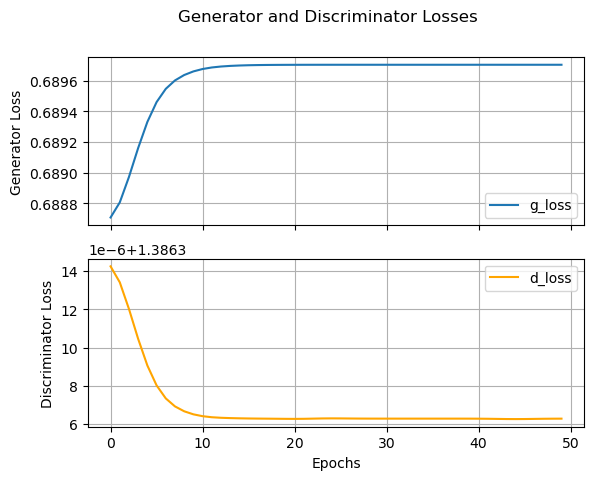

In [19]:
plot_losses(history=hist, sigma=SIGMA, save=True)

### Generate Molecules Using Trained GAN Generator 

In [20]:
def generate_smiles(generator: object, vocab: list, num_samples: int, max_length: int, device: object) -> list:
    """
    Generate SMILES strings using the trained generator
    """
    with torch.no_grad():
        generator.eval()  #set to eval mode
        noise = torch.randint(1, max_length, (num_samples, max_length)).to(device) #gen random noise with desired size
        generated_indices = generator(noise).long().detach().cpu().numpy() #make gens
        return [decode_smiles(indices, vocab) for indices in generated_indices]

##generate new smiles
# gen_smiles = generate_smiles(n_gen, vocab, num_samples=N_SAMPLES, max_length=MAX_LENGTH, device=DEVICE)
gen_smiles = generate_smiles(n_gen, vocab, num_samples=N_SAMPLES, max_length=MAX_LENGTH, device=DEVICE)

### Check Validity

In [21]:
%%capture

def process_smiles_in_parallel(smiles_list: list, function_object: object, n_processors: int) -> tuple:
    '''
    Uses python's multiprocess library to generate data
    '''
    with mp.Pool(processes=n_processors) as pool:
        results = pool.map(function_object, smiles_list)
    return results

def get_mol(smiles: str) -> object:
    '''
    Gets RDKit Generated Mol Object for a single smiles string
    '''
    return Chem.MolFromSmiles(smiles)

def calc_check_validity(smiles: str) -> int:
    '''
    Calculates validity of a single smiles string
    '''
    mol = get_mol(smiles)
    if mol:
        return 1
    else:
        return 0

##Run capture. There's a known bug with RDKit that outputs warnings.
def check_smiles_validity(smiles_list: list) -> tuple:
    """
    Check the smiles validity using RDKit (list of smiles)
    """
    valid_smiles, invalid_smiles = [], []
    for smiles in smiles_list:
        mol = get_mol(smiles)
        if mol:
            valid_smiles.append(smiles)
        else:
            invalid_smiles.append(smiles)
    return valid_smiles, invalid_smiles

valid_smiles, invalid_smiles = check_smiles_validity(gen_smiles)

### Check Novelty

In [22]:
%%time

def canonicalize_smiles(smiles: list) -> object:
    """
    Canonicalize the input SMILES string.
    """
    mol = get_mol(smiles)
    if mol:
        return Chem.MolToSmiles(mol, canonical=True)
    else:
        return None

def is_novel(canonical_smiles: str, known_canonical_smiles: list) -> int:
    '''
    Checks uniqueness of a single smiles canonical representation vs known canonical smiles
    '''
    if canonical_smiles is None:
        return None
    if canonical_smiles in known_canonical_smiles:
        return 0
    else:
        return 1

known_can_smiles = process_smiles_in_parallel(smiles_list=smilesList, function_object=canonicalize_smiles, n_processors=N_PROCESSORS)
print('\nLen known canonical smiles: ', len(known_can_smiles))

##iterate over unique valid smiles generations, then compare with known smiles
print('\nChecking Novelty of Unique GAN Generated Samples')
novel_smiles = [] 
for smiles in list(set(valid_smiles)):
    can_smiles = canonicalize_smiles(smiles)
    if is_novel(can_smiles, known_can_smiles):
        novel_smiles.append(smiles)

print('\nNovel Cnt: ', len(novel_smiles))
print('\n----------------------Novel Smiles----------------------')
for i, smiles in enumerate(novel_smiles):
    print(f'\n{i}. {smiles}')
print('\n')


Len known canonical smiles:  249456

Checking Novelty of Unique GAN Generated Samples

Novel Cnt:  21

----------------------Novel Smiles----------------------

0. CS(=O)(=O)c1ccc(-n2nnnc2CNc2cc(Cl)ccc2Cl)cc1CS(=O)(=O)c1ccc(-n2nnnc2CNc2cc(Cl)ccc2Cl)cc1CS(=O)(=O)c1ccc(-n2nnnc2CNc2cc(Cl)ccc2Cl)cc1CS(=O)(=O)c1ccc(-n2nnnc2CNc2cc(Cl)ccc2Cl)cc1CS(=O)(=O)c1ccc(-n2nnnc2CNc2cc(Cl)ccc2Cl)cc1CS(=O)(=O)c1ccc(-n2nnnc2CNc2cc(Cl)ccc2Cl)cc1CS(=O)(=O)c1ccc(-n2nnnc2CNc2cc(Cl)ccc2Cl)cc1CS(=O)(=O)c1ccc(-n2nnnc2CNc2cc(Cl)ccc2Cl)cc1CS(=O)(=O)c1ccc(-n2nnnc2CNc2cc(Cl)ccc2Cl)cc1CS(=O)(=O)c1ccc(-n2nnnc2CNc2cc(Cl)ccc2Cl)cc1

1. CC(=O)N1CCCCC1CC(=O)N1CCCCC1CC(=O)N1CCCCC1CC(=O)N1CCCCC1CC(=O)N1CCCCC1Cc1c(NS(C)(=O)=O)cccc1C(=O)N1CCCCCC1CC(=O)N1CCCCC1CC(=O)N1CCCCC1CC(=O)N1CCCCC1CC(=O)N1CCCCC1

2. Cc1cc(NC(=O)CCOC2CCOCC2)ccc1OC(C)CCSCCCNC(=O)Nc1ccccc1Cc1ccccc1Cc1cc(NC(=O)CCOC2CCOCC2)ccc1OC(C)CCSCCCNC(=O)Nc1ccccc1Cc1ccccc1CSCCCNC(=O)Nc1ccccc1Cc1ccccc1Cc1cc(NC(=O)CCOC2CCOCC2)ccc1OC(C)CCSCCCNC(=O)Nc1ccccc1Cc1ccccc1CSCCC

### Check Solubility

In [23]:
%%time

def estimate_solubility(smiles: str) -> tuple:
    '''
    Estimates aqeous solubility of a single smiles string
    '''
    mol = get_mol(smiles)
    if mol is None:
        return 0
    
    ##calc mol descriptors
    mol_weight = Descriptors.MolWt(mol)
    logP = Descriptors.MolLogP(mol)
    num_h_donors = Descriptors.NumHDonors(mol)
    num_h_acceptors = Descriptors.NumHAcceptors(mol)
    
    ##linear model to calculate solubility
    logS = -0.01 * mol_weight + 0.5 * num_h_donors + 0.5 * num_h_acceptors - logP
    return np.round(logS, 3)

aq_scores_smilesList = process_smiles_in_parallel(smiles_list=smilesList, function_object=estimate_solubility, n_processors=N_PROCESSORS)
print('\nKnown Smiles Solubility Score (logS) Stats')
print('Min: ', np.round(np.min(aq_scores_smilesList), 3))
print('Max: ', np.round(np.max(aq_scores_smilesList), 3))
print('Mean: ', np.round(np.mean(aq_scores_smilesList), 3))

GAN_aq_scores_smilesList = process_smiles_in_parallel(smiles_list=list(set(valid_smiles)), function_object=estimate_solubility, n_processors=N_PROCESSORS)
print('\nGAN Generated Smiles Solubility Score (logS) Stats')
print('Min: ', np.round(np.min(GAN_aq_scores_smilesList), 3))
print('Max: ', np.round(np.max(GAN_aq_scores_smilesList), 3))
print('Mean: ', np.round(np.mean(GAN_aq_scores_smilesList), 3))

##iterate over unique valid smiles generations, then compare with known smiles
print('\nGAN Generated Smiles Solubility Score (logS)')
for smiles in list(set(valid_smiles)):
    logS = estimate_solubility(smiles)
    print('Solubility Score: ', logS)
print('\n')


Known Smiles Solubility Score (logS) Stats
Min:  -12.329
Max:  8.422
Mean:  -3.172

GAN Generated Smiles Solubility Score (logS) Stats
Min:  -57.6
Max:  6.763
Mean:  -30.079

GAN Generated Smiles Solubility Score (logS)
Solubility Score:  -28.447
Solubility Score:  -17.057
Solubility Score:  -46.945
Solubility Score:  -57.6
Solubility Score:  -26.904
Solubility Score:  6.763
Solubility Score:  -32.081
Solubility Score:  -40.899
Solubility Score:  -3.416
Solubility Score:  -25.241
Solubility Score:  -31.234
Solubility Score:  -36.585
Solubility Score:  -43.441
Solubility Score:  -27.146
Solubility Score:  -15.497
Solubility Score:  -51.738
Solubility Score:  -36.322
Solubility Score:  -45.755
Solubility Score:  -48.351
Solubility Score:  -5.273
Solubility Score:  -18.485


CPU times: user 377 ms, sys: 1.12 s, total: 1.5 s
Wall time: 10.2 s


### Calculate Druglikeness

In [24]:
%%time

from rdkit.Chem import QED

def calculate_qed(smiles: list) -> float:
    """
    Calculate Quantitative Estimation of Drug-likeness score (QED) for a single smiles string
    """
    mol = get_mol(smiles)
    if mol is None:
        return None
        
    qed_score = QED.qed(mol)
    return np.round(qed_score, 3)

qed_scores_smilesList = process_smiles_in_parallel(smiles_list=smilesList, function_object=calculate_qed, n_processors=N_PROCESSORS)
print('\nKnown Smiles Druglikeliness Score (QED) Stats')
print('Min: ', np.round(np.min(qed_scores_smilesList), 3))
print('Max: ', np.round(np.max(qed_scores_smilesList), 3))
print('Mean: ', np.round(np.mean(qed_scores_smilesList), 3))
print('Std: ', np.round(np.std(qed_scores_smilesList), 3))

GAN_qed_scores_smilesList = process_smiles_in_parallel(smiles_list=list(set(valid_smiles)), function_object=calculate_qed, n_processors=N_PROCESSORS)
print('\nGAN Generated Smiles Druglikeliness Score (QED) Stats')
print('Min: ', np.round(np.min(GAN_qed_scores_smilesList), 3))
print('Max: ', np.round(np.max(GAN_qed_scores_smilesList), 3))
print('Mean: ', np.round(np.mean(GAN_qed_scores_smilesList), 3))
print('Std: ', np.round(np.std(GAN_qed_scores_smilesList), 3))

print('\nGAN Generated Smiles Druglikeliness Score (QED)')
for i, smiles in enumerate(list(set(valid_smiles))):
    qed_score = calculate_qed(smiles)
    print(f"{i}. QED score: {qed_score}")
print('\n')


Known Smiles Druglikeliness Score (QED) Stats
Min:  0.117
Max:  0.948
Mean:  0.732
Std:  0.139

GAN Generated Smiles Druglikeliness Score (QED) Stats
Min:  0.117
Max:  0.948
Mean:  0.732
Std:  0.139

GAN Generated Smiles Druglikeliness Score (QED)
0. QED score: 0.017
1. QED score: 0.121
2. QED score: 0.016
3. QED score: 0.007
4. QED score: 0.019
5. QED score: 0.016
6. QED score: 0.012
7. QED score: 0.017
8. QED score: 0.053
9. QED score: 0.017
10. QED score: 0.017
11. QED score: 0.017
12. QED score: 0.017
13. QED score: 0.016
14. QED score: 0.13
15. QED score: 0.016
16. QED score: 0.035
17. QED score: 0.016
18. QED score: 0.016
19. QED score: 0.058
20. QED score: 0.013


CPU times: user 633 ms, sys: 1.23 s, total: 1.87 s
Wall time: 46.6 s


### Calculate Synthesizeability

In [25]:
from rdkit.Chem import rdMolDescriptors

def estimate_synthesizeability(smiles):
    '''
    Calculates synthesizeability using synthetic RDKits synthetic accessibility score
    '''
    mol = get_mol(smiles)
    if mol is None:
        return None
    
    ##get discriptors to calculate a rough estimation of mol synthesizeability
    mol_weight = Descriptors.MolWt(mol)
    n_rings = Descriptors.RingCount(mol)
    n_heteroatoms = Descriptors.NumHeteroatoms(mol)
    
    ##less heteroatoms, rings, and smaller molecules are generally easier to synthesize
    synth_score = 0.5 * (mol_weight / 100) + 2 * n_rings + n_heteroatoms
    return np.round(synth_score, 3)

print('\nGAN Generated Smiles Synthesizeability Score (SA) Examples')
for i, smiles in enumerate(list(set(valid_smiles))):
    synth_score = estimate_synthesizeability(smiles)
    print(f"{i}. SA score: {synth_score}")
print('\n')

sa_scores_smilesList = process_smiles_in_parallel(smiles_list=smilesList, function_object=estimate_synthesizeability, n_processors=N_PROCESSORS)
print('\nKnown Smiles Synthesizeability Score (SA) Stats')
print('Min: ', np.round(np.min(sa_scores_smilesList), 3))
print('Max: ', np.round(np.max(sa_scores_smilesList), 3))
print('Mean: ', np.round(np.mean(sa_scores_smilesList), 3))
print('Std: ', np.round(np.std(sa_scores_smilesList), 3))

GAN_sa_scores_smilesList = process_smiles_in_parallel(smiles_list=list(set(valid_smiles)), function_object=estimate_synthesizeability, n_processors=N_PROCESSORS)
print('\nGAN Generated Synthesizeability Score (SA) Stats')
print('Min: ', np.round(np.min(GAN_sa_scores_smilesList), 3))
print('Max: ', np.round(np.max(GAN_sa_scores_smilesList), 3))
print('Mean: ', np.round(np.mean(GAN_sa_scores_smilesList), 3))
print('Std: ', np.round(np.std(GAN_sa_scores_smilesList), 3))


GAN Generated Smiles Synthesizeability Score (SA) Examples
0. SA score: 179.823
1. SA score: 53.185
2. SA score: 98.736
3. SA score: 173.577
4. SA score: 48.119
5. SA score: 121.724
6. SA score: 105.077
7. SA score: 170.785
8. SA score: 89.673
9. SA score: 135.529
10. SA score: 115.43
11. SA score: 105.98
12. SA score: 161.774
13. SA score: 178.074
14. SA score: 46.269
15. SA score: 95.632
16. SA score: 91.424
17. SA score: 138.282
18. SA score: 97.702
19. SA score: 24.915
20. SA score: 70.822



Known Smiles Synthesizeability Score (SA) Stats
Min:  1.781
Max:  28.498
Mean:  13.268
Std:  3.412

GAN Generated Synthesizeability Score (SA) Stats
Min:  24.915
Max:  179.823
Mean:  109.644
Std:  45.103


### Get Summary Stats

In [26]:
def summary_stats(val_smiles: list, inv_smiles: list) -> list:
    '''
    Basic Stats
    '''
    tot_gen_cnt = len(valid_smiles) + len(invalid_smiles)
    valid_cnt = len(valid_smiles)
    unique_valid_cnt = len(set(valid_smiles))
    invalid_cnt = len(invalid_smiles)
    unique_invalid_cnt = len(list(set(invalid_smiles)))
    unique_valid_perc = np.round(100*(unique_valid_cnt/tot_gen_cnt), 3)
    unique_invalid_perc = np.round(100*(unique_invalid_cnt/tot_gen_cnt), 3)
    unique_val_ratio = np.round(unique_valid_cnt/unique_invalid_cnt, 2)
    
    print("total generated cnt: ", tot_gen_cnt)
    print("valid cnt: ", valid_cnt)
    print("invalid Count: ", invalid_cnt)
    print("unique valid cnt: ", unique_valid_cnt)
    print("unique invalid cnt: ", unique_invalid_cnt)
    print("percent unique valid: ", unique_valid_perc)
    print("percent unique invalid: ", unique_invalid_perc)
    print("ratio unique_valid/unique_invalid: ", unique_val_ratio)

    stats = [tot_gen_cnt, valid_cnt, unique_valid_cnt, invalid_cnt, unique_invalid_cnt, unique_valid_perc, 
             unique_invalid_perc, unique_val_ratio]
    return stats

print("\n\n==================================================Stats==================================================")
basic_stats = summary_stats(valid_smiles, invalid_smiles)

print("\n\n===============================================Valid SMILES===============================================")
for i, smiles in enumerate(list(set(valid_smiles))[: 10]):
    print(f'\n{i}.  {smiles}')

print("\n\n===============================================Inalid SMILES===============================================")
for i, smiles in enumerate(list(set(invalid_smiles))[: 10]):
    print(f'\n{i}.  {smiles}')



==================================================Stats==================================================
total generated cnt:  1000
valid cnt:  309
invalid Count:  691
unique valid cnt:  21
unique invalid cnt:  137
percent unique valid:  2.1
percent unique invalid:  13.7
ratio unique_valid/unique_invalid:  0.15


===============================================Valid SMILES===============================================

0.  CS(=O)(=O)c1ccc(-n2nnnc2CNc2cc(Cl)ccc2Cl)cc1CS(=O)(=O)c1ccc(-n2nnnc2CNc2cc(Cl)ccc2Cl)cc1CS(=O)(=O)c1ccc(-n2nnnc2CNc2cc(Cl)ccc2Cl)cc1CS(=O)(=O)c1ccc(-n2nnnc2CNc2cc(Cl)ccc2Cl)cc1CS(=O)(=O)c1ccc(-n2nnnc2CNc2cc(Cl)ccc2Cl)cc1CS(=O)(=O)c1ccc(-n2nnnc2CNc2cc(Cl)ccc2Cl)cc1CS(=O)(=O)c1ccc(-n2nnnc2CNc2cc(Cl)ccc2Cl)cc1CS(=O)(=O)c1ccc(-n2nnnc2CNc2cc(Cl)ccc2Cl)cc1CS(=O)(=O)c1ccc(-n2nnnc2CNc2cc(Cl)ccc2Cl)cc1CS(=O)(=O)c1ccc(-n2nnnc2CNc2cc(Cl)ccc2Cl)cc1

1.  CC(=O)N1CCCCC1CC(=O)N1CCCCC1CC(=O)N1CCCCC1CC(=O)N1CCCCC1CC(=O)N1CCCCC1Cc1c(NS(C)(=O)=O)cccc1C(=O)N1CCCCCC1CC(=O)N1CCCCC1CC(=

### Visualize GAN Generated Molecules

CPU times: user 40.1 ms, sys: 61 µs, total: 40.2 ms
Wall time: 41.8 ms


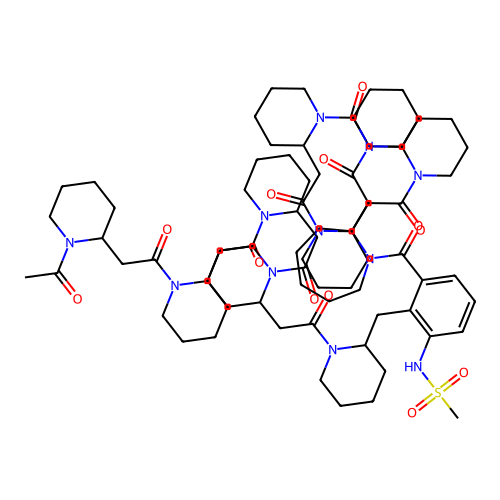

In [27]:
%%time

from rdkit.Chem import Draw

def plot_single_mol(smiles: str, size=(400, 400)) -> object:
    '''
    Plot Only a single molecule
    '''
    mol = get_mol(smiles)
    img = Draw.MolToImage(mol, size=(500, 500))
    return img

##plot a single example
img = plot_single_mol(list(set(valid_smiles))[1])
img.save(WRITEPATH + '/GAN_generated_img.png')
img

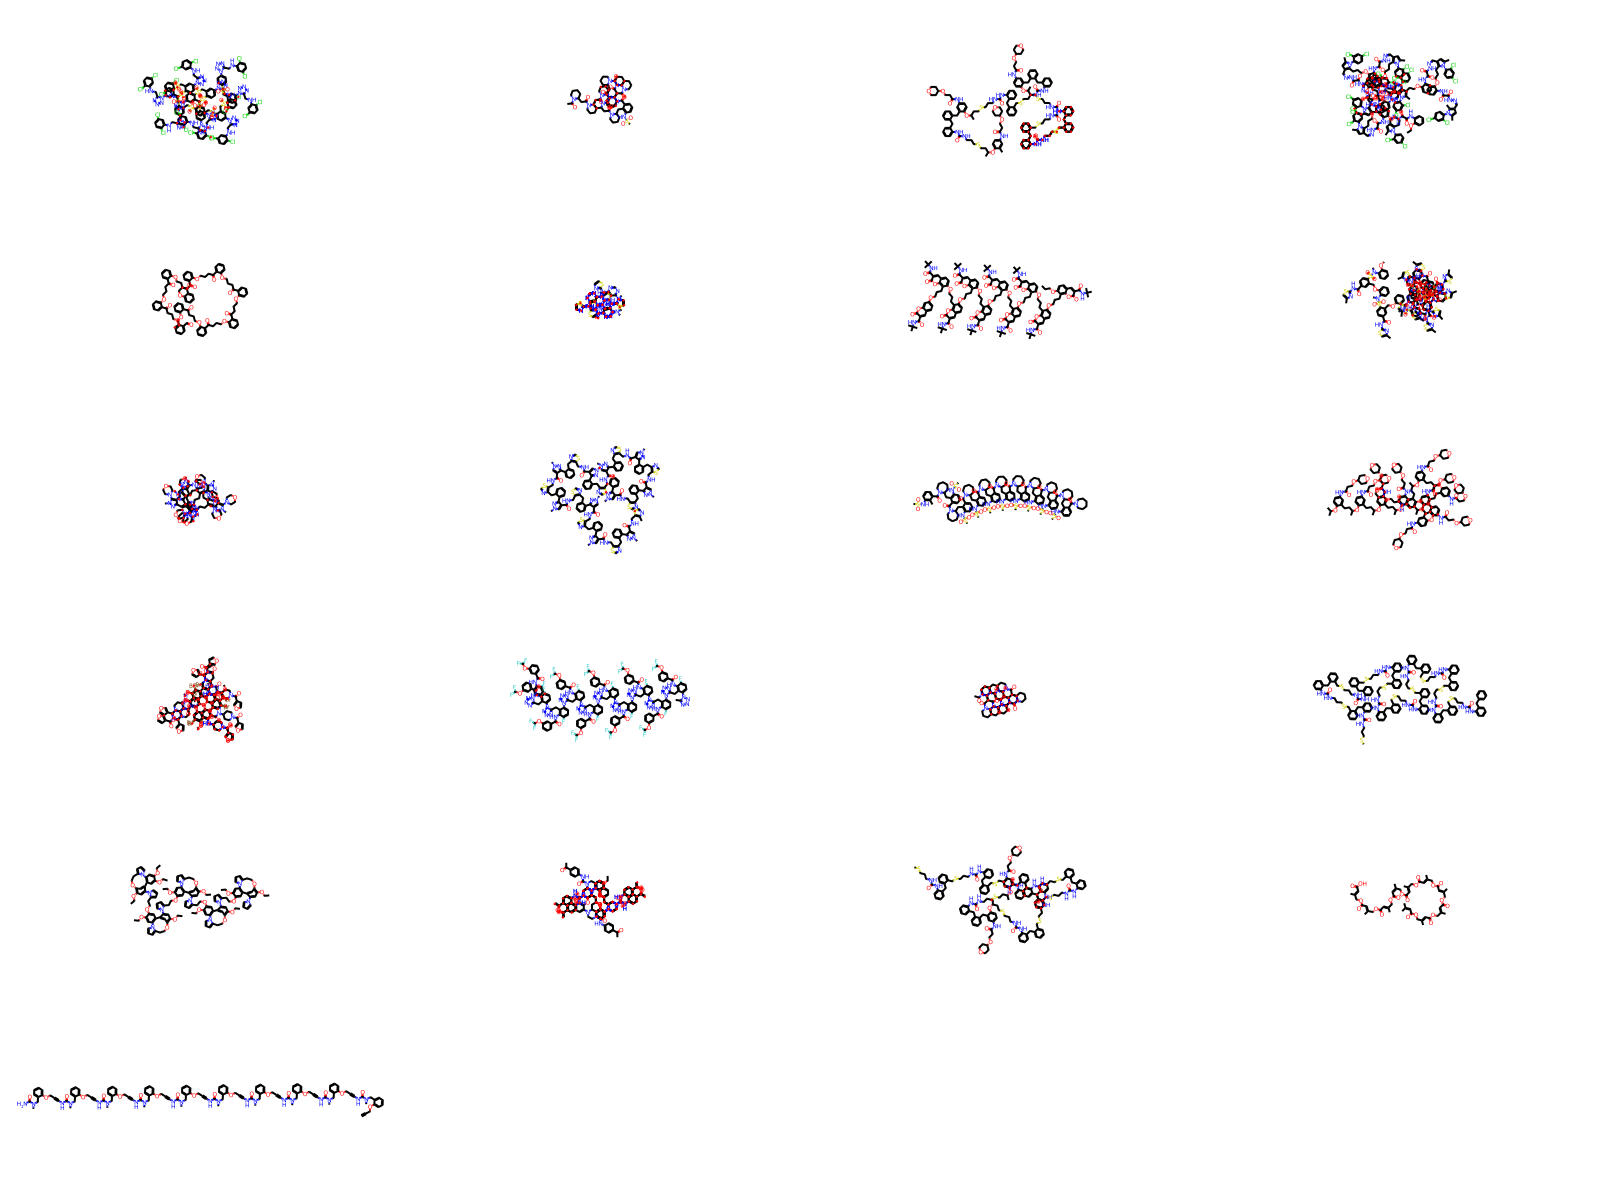

In [28]:
def plot_smiles_grid(smiles_list: list, save=True, grid_size=(4, 4)) -> None:
    from PIL import Image
    from io import BytesIO
    '''
    Plots a grid of molecule images.
    '''
    mols = [get_mol(smile) for smile in smiles_list]
    img = Draw.MolsToGridImage(mols, molsPerRow=grid_size[1], subImgSize=(400, 200), useSVG=False, returnPNG=True)

    return img

grid_img = plot_smiles_grid(smiles_list=list(set(valid_smiles)))
with open(WRITEPATH + "/grid_gan_generated.png", "wb") as f:
    f.write(grid_img.data)

grid_img

In [29]:
##clean and time
gc.collect()
torch.cuda.empty_cache()
tf = time.time()
print('Total Runtime: ', np.round(tf - t0, 3))

Total Runtime:  2525.157


### REFERENCES

Alqahtani, H. E. (2019, Dec 19). Applications of Generative Adversarial Networks (GANS): An Updated Review.

Arjovsky, M. E. (2017, Jan 26). Wasserstein GAN.

Bidisha, S. (2019). NeVAE: A Deep Generative Model for Molecular Graphs.

Goodfellow, E. A. (2014, June 10). Generative Adversarial Networks.

Mangalam, K. G. (2021, Dec 29). Overcoming Mode Collapse with Adaptive Multi Adversarial Training.

Nicola De Cao, T. K. (2018). MolGAN: An Implicit Generative Model for Small Molecular Graphs. Stochholm, Sweden.